# **Empirical Analysis of AI Coding Agent Collaboration Pattern**

Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


Loading data

In [6]:
print("="*70)
print("LOADING AND ANALYZING AIDEV DATASET")
print("="*70)

print("\nLoading data...")
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
print(f"✓ Loaded {len(pr_df):,} PRs and {len(repo_df):,} repositories")

LOADING AND ANALYZING AIDEV DATASET

Loading data...
✓ Loaded 932,791 PRs and 116,211 repositories


Data Prep

In [7]:
print("\nApplying filters...")
initial = len(pr_df)
pr_df = pr_df[pr_df['state'].isin(['merged', 'closed'])].copy()
pr_df['created_at'] = pd.to_datetime(pr_df['created_at'])
pr_df = pr_df[(pr_df['created_at'] >= '2025-01-01') & (pr_df['created_at'] <= '2025-08-01')]
print(f"✓ Filtered: {len(pr_df):,} PRs ({len(pr_df)/initial*100:.1f}%)")


Applying filters...
✓ Filtered: 859,377 PRs (92.1%)


In [8]:
pr_df['merged_at'] = pd.to_datetime(pr_df['merged_at'])
pr_df['is_merged'] = pr_df['merged_at'].notna().astype(int)

print(f"\nState distribution: {pr_df['state'].value_counts().to_dict()}")
print(f"PRs with merged_at: {pr_df['merged_at'].notna().sum():,}")
print(f"Actual merge rate: {pr_df['is_merged'].mean()*100:.1f}%")
pr_df['description_length'] = pr_df['body'].fillna('').str.len()

if 'closed_at' in pr_df.columns:
    pr_df['closed_at'] = pd.to_datetime(pr_df['closed_at'])
    pr_df['time_to_close_hours'] = (pr_df['closed_at'] - pr_df['created_at']).dt.total_seconds() / 3600

pr_df['month'] = pr_df['created_at'].dt.to_period('M').astype(str)

# Merge repo data
if 'stars' in repo_df.columns:
    pr_df = pr_df.merge(repo_df[['id', 'stars']], left_on='repo_id', right_on='id',
                        how='left', suffixes=('', '_repo'))
    pr_df['stargazers_count'] = pr_df['stars']

print(f"\n✓ Final dataset: {len(pr_df):,} PRs")
print(f"Agents: {pr_df['agent'].value_counts().to_dict()}")


State distribution: {'closed': 859377}
PRs with merged_at: 789,822
Actual merge rate: 91.9%

✓ Final dataset: 859,377 PRs
Agents: {'OpenAI_Codex': 761032, 'Copilot': 40215, 'Devin': 27516, 'Cursor': 25880, 'Claude_Code': 4734}


## **RQ1: ACCEPTANCE RATES**


RQ1: ACCEPTANCE RATES BY AGENT

               acceptance_rate  total_prs  merged_prs  rejected_prs
agent                                                             
Claude_Code          0.833333       4734        3945           789
Copilot              0.740893      40215       29795         10420
Cursor               0.897566      25880       23229          2651
Devin                0.685165      27516       18853          8663
OpenAI_Codex         0.938200     761032      714000         47032

Chi-square test: χ²=41774.33, p=0.0000e+00
→ SIGNIFICANT: Acceptance rates differ significantly between agents


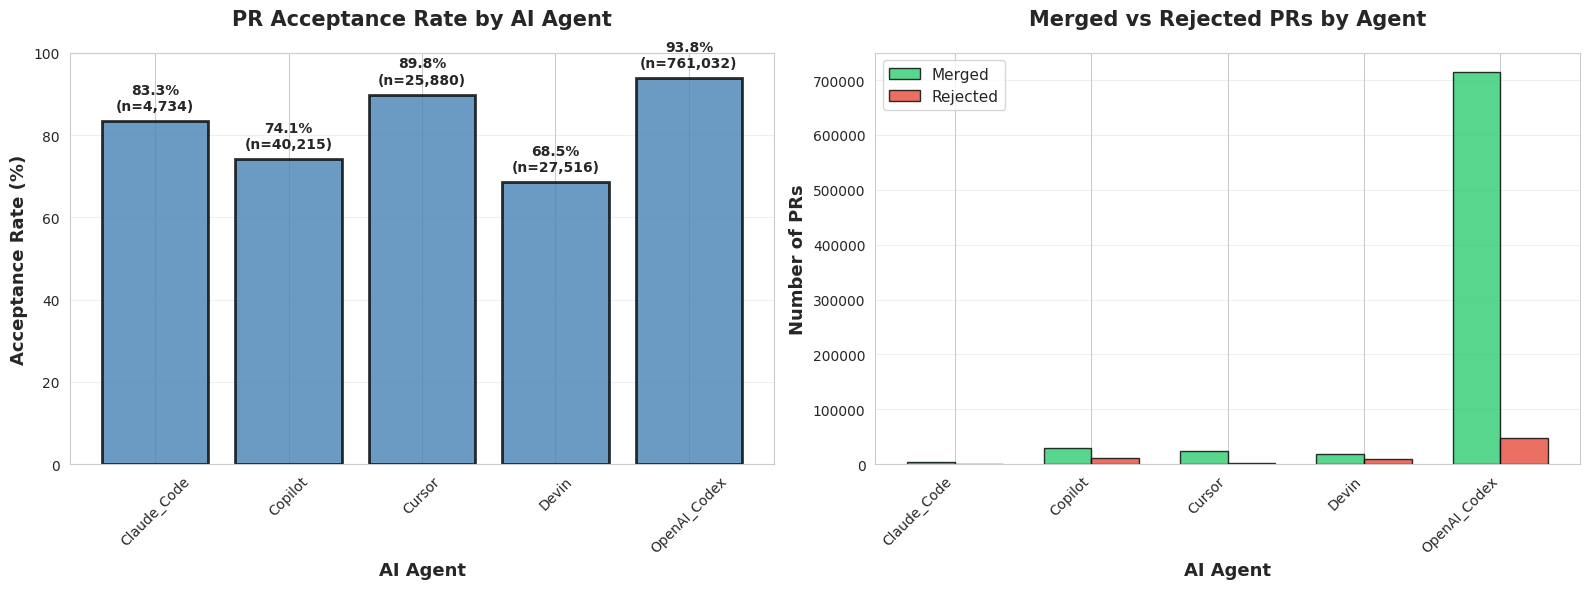

In [9]:

print("\n" + "="*70)
print("RQ1: ACCEPTANCE RATES BY AGENT")
print("="*70)

acceptance = pr_df.groupby('agent')['is_merged'].agg(['mean', 'count', 'sum'])
acceptance.columns = ['acceptance_rate', 'total_prs', 'merged_prs']
acceptance['rejected_prs'] = acceptance['total_prs'] - acceptance['merged_prs']
print("\n", acceptance)

# Statistical test
contingency = pd.crosstab(pr_df['agent'], pr_df['is_merged'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.2f}, p={p_value:.4e}")
if p_value < 0.05:
    print("→ SIGNIFICANT: Acceptance rates differ significantly between agents")
else:
    print("→ NOT SIGNIFICANT: No significant difference in acceptance rates")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Acceptance rates
agents = acceptance.index
rates = acceptance['acceptance_rate'] * 100
bars = ax1.bar(agents, rates, color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xlabel('AI Agent', fontsize=13, fontweight='bold')
ax1.set_ylabel('Acceptance Rate (%)', fontsize=13, fontweight='bold')
ax1.set_title('PR Acceptance Rate by AI Agent', fontsize=15, fontweight='bold', pad=20)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)
for bar, rate, count in zip(bars, rates, acceptance['total_prs']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{rate:.1f}%\n(n={count:,})', ha='center', va='bottom',
            fontsize=10, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Chart 2: Merged vs Rejected
x = np.arange(len(acceptance))
width = 0.35
ax2.bar(x - width/2, acceptance['merged_prs'], width, label='Merged',
        color='#2ecc71', alpha=0.8, edgecolor='black')
ax2.bar(x + width/2, acceptance['rejected_prs'], width, label='Rejected',
        color='#e74c3c', alpha=0.8, edgecolor='black')
ax2.set_xlabel('AI Agent', fontsize=13, fontweight='bold')
ax2.set_ylabel('Number of PRs', fontsize=13, fontweight='bold')
ax2.set_title('Merged vs Rejected PRs by Agent', fontsize=15, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(acceptance.index, rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

RQ1: TIME TO CLOSE


RQ1: TIME TO CLOSE ANALYSIS

                 median       mean   count
agent                                    
Claude_Code   0.429306  19.774994    4734
Copilot       0.716111  28.825454   40215
Cursor        0.025556   8.095473   25880
Devin         0.836944  53.681627   27516
OpenAI_Codex  0.008889   4.916417  761032

Kruskal-Wallis test: H=114089.21, p=0.0000e+00


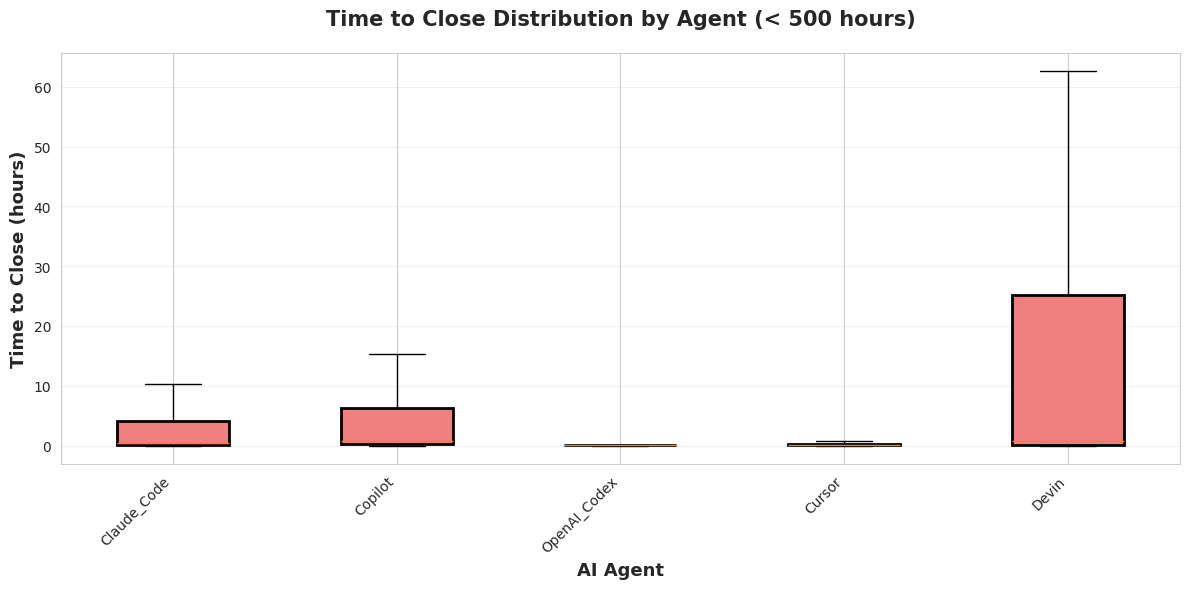

In [10]:

if 'time_to_close_hours' in pr_df.columns:
    print("\n" + "="*70)
    print("RQ1: TIME TO CLOSE ANALYSIS")
    print("="*70)

    time_stats = pr_df[pr_df['time_to_close_hours'].notna()].groupby('agent')['time_to_close_hours'].agg(['median', 'mean', 'count'])
    print("\n", time_stats)

    # Kruskal-Wallis test
    groups = [pr_df[(pr_df['agent'] == agent) & (pr_df['time_to_close_hours'].notna())]['time_to_close_hours']
              for agent in pr_df['agent'].unique()]
    h_stat, p_value = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis test: H={h_stat:.2f}, p={p_value:.4e}")

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    data_plot = [pr_df[(pr_df['agent'] == agent) & (pr_df['time_to_close_hours'] < 500)]['time_to_close_hours'].dropna()
                 for agent in pr_df['agent'].unique()]
    bp = ax.boxplot(data_plot, labels=pr_df['agent'].unique(), patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    ax.set_xlabel('AI Agent', fontsize=13, fontweight='bold')
    ax.set_ylabel('Time to Close (hours)', fontsize=13, fontweight='bold')
    ax.set_title('Time to Close Distribution by Agent (< 500 hours)', fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## **RQ2: PR SIZE IMPACT**


RQ2: DESCRIPTION LENGTH IMPACT ON ACCEPTANCE

                         mean   count
desc_category                       
Very Short\n(<100)  0.914806    9766
Short\n(100-500)    0.936898  733418
Medium\n(500-2K)    0.821100   69575
Long\n(>2K)         0.769929   38449


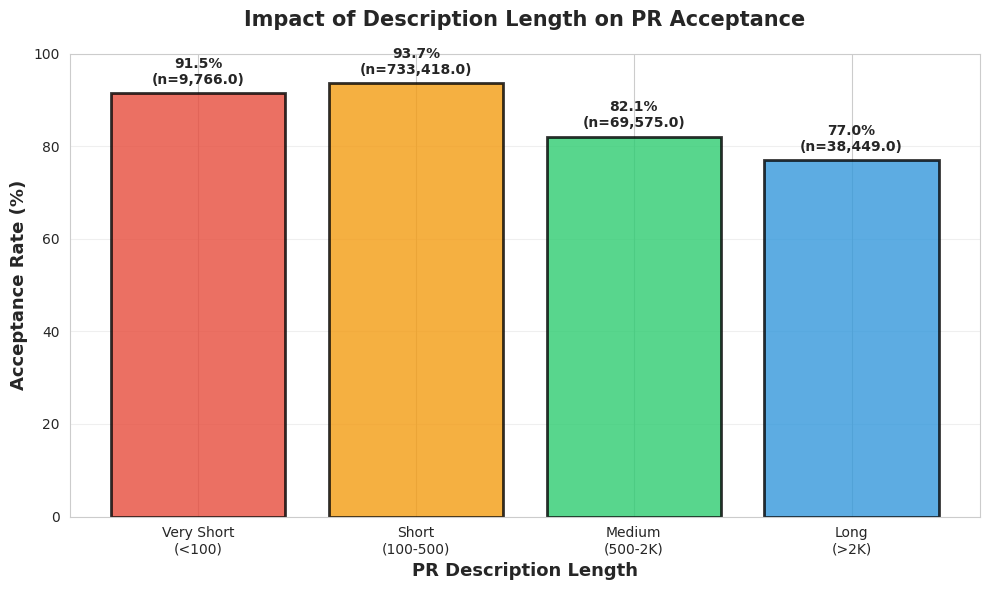

In [11]:

print("\n" + "="*70)
print("RQ2: DESCRIPTION LENGTH IMPACT ON ACCEPTANCE")
print("="*70)

pr_df['desc_category'] = pd.cut(pr_df['description_length'],
                                 bins=[0, 100, 500, 2000, float('inf')],
                                 labels=['Very Short\n(<100)', 'Short\n(100-500)',
                                        'Medium\n(500-2K)', 'Long\n(>2K)'])

desc_acceptance = pr_df.groupby('desc_category', observed=True)['is_merged'].agg(['mean', 'count'])
print("\n", desc_acceptance)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(desc_acceptance)), desc_acceptance['mean'] * 100,
              color=['#e74c3c', '#f39c12', '#2ecc71', '#3498db'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_xticks(range(len(desc_acceptance)))
ax.set_xticklabels(desc_acceptance.index)
ax.set_xlabel('PR Description Length', fontsize=13, fontweight='bold')
ax.set_ylabel('Acceptance Rate (%)', fontsize=13, fontweight='bold')
ax.set_title('Impact of Description Length on PR Acceptance', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, desc_acceptance['mean'] * 100)):
    ax.text(i, val + 2, f'{val:.1f}%\n(n={desc_acceptance.iloc[i]["count"]:,})',
            ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## **RQ3: TEMPORAL TRENDS**


RQ3: TEMPORAL ADOPTION TRENDS

 agent    Claude_Code  Copilot  Cursor  Devin  OpenAI_Codex
month                                                     
2025-01            0        0       1   2425             0
2025-02           39        0       5   3229             0
2025-03          165        8       7   3595             0
2025-04           34       24       6   5364             0
2025-05          385     4689     115   5619         62430
2025-06         1435    12942    2720   3972        402026
2025-07         2676    22552   23026   3312        296576


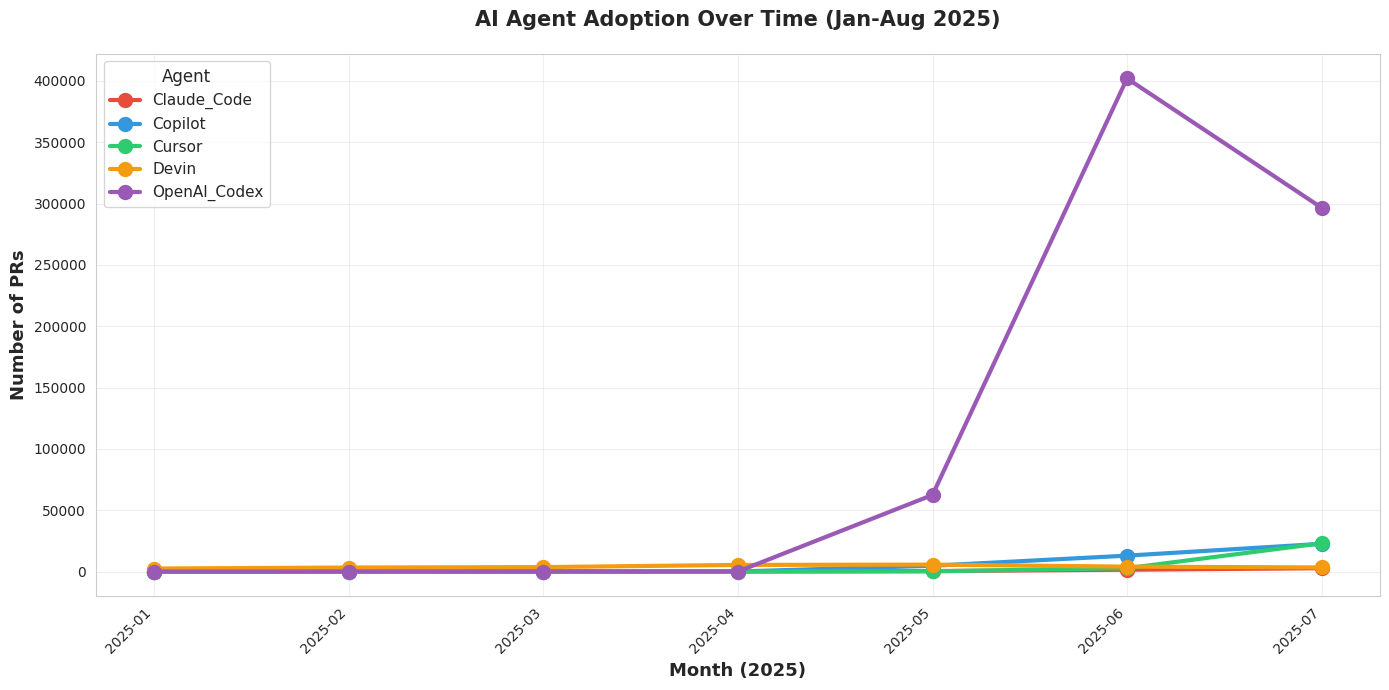

In [13]:
print("\n" + "="*70)
print("RQ3: TEMPORAL ADOPTION TRENDS")
print("="*70)

temporal = pr_df.groupby(['month', 'agent']).size().unstack(fill_value=0)
print("\n", temporal)

fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
for i, agent in enumerate(temporal.columns):
    ax.plot(range(len(temporal)), temporal[agent], marker='o', label=agent,
            linewidth=3, markersize=10, color=colors[i % len(colors)])
ax.set_xlabel('Month (2025)', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of PRs', fontsize=13, fontweight='bold')
ax.set_title('AI Agent Adoption Over Time (Jan-Aug 2025)', fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Agent', fontsize=11, title_fontsize=12)
ax.set_xticks(range(len(temporal)))
ax.set_xticklabels(temporal.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# **Summary**

In [14]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE - KEY FINDINGS")
print("="*70)
print(f"\n✓ Analyzed: {len(pr_df):,} AI-generated PRs")
print(f"✓ Time period: January - August 2025")
print(f"✓ Overall acceptance rate: {pr_df['is_merged'].mean()*100:.1f}%")
print(f"\n✓ Best performing agent: {acceptance['acceptance_rate'].idxmax()} ({acceptance['acceptance_rate'].max()*100:.1f}%)")
print(f"✓ Most active agent: {acceptance['total_prs'].idxmax()} ({acceptance['total_prs'].max():,} PRs)")

pr_df.to_csv('aidev_analysis_data.csv', index=False)
print("\n✓ Saved: aidev_analysis_data.csv")


ANALYSIS COMPLETE - KEY FINDINGS

✓ Analyzed: 859,377 AI-generated PRs
✓ Time period: January - August 2025
✓ Overall acceptance rate: 91.9%

✓ Best performing agent: OpenAI_Codex (93.8%)
✓ Most active agent: OpenAI_Codex (761,032 PRs)

✓ Saved: aidev_analysis_data.csv
